In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
import matplotlib.dates as mdates

import tkp.db
import tkp.config
import logging
import csv
import time
import sys
import itertools

import numpy as np
import pandas as pd
import scipy as sp

from astropy import units as u
from astropy.coordinates import SkyCoord

import numbers
import math
import scipy
from scipy.stats import norm
from scipy.stats import sem
from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf

import pylab

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'

%matplotlib notebook

logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def num_err(num, err, n=1):
    '''Return number rounded based on error'''
    return np.around(num,int(-(np.floor(np.log10(nsf(err,n=n)))))), nsf(err,n=n)

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata


In [3]:
def dump_trans(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    # find all the new, candidate transient, sources detected by the pipeline
    transients_query = """
    SELECT  tr.runcat
           ,tr.newsource_type
           ,im.rms_min
           ,im.rms_max
           ,im.detection_thresh
           ,ex.f_int
    FROM newsource tr
         ,image im
         ,extractedsource ex
    WHERE tr.previous_limits_image = im.id
      AND tr.trigger_xtrsrc = ex.id
    """
    
    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    print "Found", len(transients), "new sources"
    return transients, sources

def dump_sources(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )
    # extract the properties and variability parameters for all the running catalogue sources in the dataset
    sources_query = """\
    SELECT  im.taustart_ts
            ,im.tau_time
            ,ex.f_int
            ,ex.f_int_err
            ,ax.xtrsrc
            ,ex.extract_type
            ,rc.id as runcatid
            ,rc.dataset
            ,ex.ra
            ,ex.decl
            ,rc.wm_ra
            ,rc.wm_decl
            ,ex.ra_err
            ,ex.decl_err
            ,im.band
            ,ax.v_int
            ,ax.eta_int
            ,ax.f_datapoints
            ,im.freq_eff
    FROM extractedsource ex
         ,assocxtrsource ax
         ,image im
         ,runningcatalog rc
         ,runningcatalog_flux rf
    WHERE rf.runcat = rc.id
      and ax.runcat = rc.id
      AND ax.xtrsrc = ex.id
      and ex.image = im.id
      AND rc.dataset = %s
      ORDER BY rc.id
    """
    cursor = tkp.db.execute(sources_query, (dataset_id,))
    sources = tkp.db.generic.get_db_rows_as_dicts(cursor)

    print "Found", len(sources), "source datapoints"

    return sources 

In [4]:
def distSquared(p0, p1):
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 3.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [5]:
def retrieve_source(full_data, run_id):
    source_df = full_data[(full_data.runcatid == run_id)]
    pd.to_datetime(source_df.taustart_ts)
    source_df = source_df.groupby('taustart_ts', as_index=False).mean()
    source_df.set_index(source_df.taustart_ts, inplace=True)
    return source_df


def plot_lightcurve(full_data, run_id, ion_sub=False, roll_len = 1*60, roll_type = 'triang', stdout=True):

    source_df = full_data[(full_data.runcatid == run_id)]
    if stdout:
        print source_df.wm_ra.iloc[0], source_df.wm_decl.iloc[0]

    pd.to_datetime(source_df.taustart_ts)
    source_df = source_df.groupby('taustart_ts', as_index=False).mean()
    source_df.set_index(source_df.taustart_ts, inplace=True)

    if ion_sub:
        rolling = source_df.f_int.rolling(roll_len, win_type=roll_type)
        source_df.f_int = source_df.f_int-rolling.mean()


    plt.rcParams['font.size']=16
    plt.rcParams['axes.labelsize']='large'
    plt.rcParams['axes.titlesize']='large'
    pylab.rcParams['legend.loc'] = 'best'

    ylim = [np.nanmean(source_df.f_int)-6.0*np.nanstd(source_df.f_int),
            np.nanmean(source_df.f_int)+10.0*np.nanstd(source_df.f_int)]



    myFmt = mdates.DateFormatter('%H:%M')
    source_df["taustart_ts"] = pd.to_datetime(source_df["taustart_ts"])
    obs_dates = np.unique([100*x.month+x.day for x in source_df["taustart_ts"]])

    n_hours = np.array([]) 
    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        n_hours = np.append(n_hours, len(np.unique(pd.DatetimeIndex(source_df["taustart_ts"][index]).hour)))
    hour_ratio = [i/n_hours.sum() for i in n_hours ]
    gs_ratio = np.append((hour_ratio)/min(hour_ratio),1)

    gs = gridspec.GridSpec(1, len(obs_dates)+1, width_ratios=gs_ratio) 

    figcount = 0
    figure = plt.figure(figsize=(4*len(obs_dates),6))

    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        ax = plt.subplot(gs[figcount])
        ax.locator_params(nticks=6)
        ax.errorbar(source_df["taustart_ts"].values[index],
                    source_df["f_int"].values[index],
                    yerr=source_df["f_int_err"].values[index],
                    fmt=".",c="#1f77b4",ecolor="#ff7f0e")

        if figcount > 0:
            ax.set_yticks([])
        if figcount ==0:
            plt.ylabel("Flux [Jy]")
            ax.yaxis.set_ticks_position('left')
        if stdout:
            print source_df["taustart_ts"].values[index][0]
        plt.annotate("{}-{}".format(pd.DatetimeIndex(source_df["taustart_ts"].values[index]).day[0],
                                    pd.DatetimeIndex(source_df["taustart_ts"].values[index]).month[0]),
                                    xy=(0.95,0.95), xycoords='axes fraction',
                                    horizontalalignment='right', verticalalignment='top',fontsize=16)

        plt.xticks(rotation=90)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(myFmt)
        figcount+=1

    hist_index = np.isfinite(source_df["f_int"]) #& (source_df.extract_type == 0)
    plt.subplot(gs[figcount])
    (mu, sigma) = norm.fit(source_df["f_int"].iloc[hist_index].values)
    n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
                                   bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")
    y = mlab.normpdf( bins, mu, sigma)
    if stdout:
        print "Gaus fit: mu {}, sigma {}".format(round(mu,3),round(sigma,3))
    
    l = plt.plot(y,bins,'r--', linewidth=2)
    # plt.title("Source: N = {}".format(len(source_df["f_int"].values[np.isfinite(source_df["f_int"])])))
    plt.annotate("Total N:\n{}".format(len(source_df["f_int"].values[hist_index])),
                                xy=(0.95,0.95), xycoords='axes fraction',
                                horizontalalignment='right', verticalalignment='top',fontsize=16)
    # plt.ylabel("Normalized N")
    plt.yticks([])
    plt.ylim(ylim)
    plt.xticks(rotation=90)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    return figure
#     plt.show()
# fig.text(0.5, 0.04, 'date', ha='center')
# plt.tight_layout()
# print(source_df["wm_ra"].values[0],source_df["wm_decl"].values[1])
# plt.savefig("{}_multiday_lightcurve.png".format(key))



In [6]:
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'
# database = 'raw_16SB'
# database = 'flux_16SB'
# database = 'fluxcal_db'

databases = ['higher_201702250130','lower_201702250130']
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING

## Load multiple databases.

In [7]:
# db._configured = False
# del data
data = pd.DataFrame([])

for dbname in databases:
    print "database name: ",  dbname

    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
    
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=dbname)
    db.connect()
    session = db.Session()

    sources = dump_sources(dbname,1, engine, host, port, user, password)

    if len(data) == 0:
        data = pd.DataFrame(sources)
        del sources
        data.taustart_ts = pd.to_datetime(data.taustart_ts)
        data.band = np.ones(len(data.band), dtype=int)

    else:
        new_data = pd.DataFrame(sources)
        del sources

        new_data.taustart_ts = pd.to_datetime(new_data.taustart_ts)
        new_data.runcatid += data.runcatid.iloc[-1]
        new_data.band = (data.band.iloc[-1]+1)*np.ones(len(new_data.band), dtype=int)

        data = pd.concat([data,new_data], ignore_index=True)
        del new_data
        
    db._configured = False
    del db, session

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/higher_201702250130
INFO:tkp.db.database:connecting to database...


database name:  higher_201702250130
Found 976110 source datapoints


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/lower_201702250130
INFO:tkp.db.database:connecting to database...


database name:  lower_201702250130
Found 1402510 source datapoints


#### Save all data

In [ ]:
all_data_name = "all_raw_data.csv"
data.to_csv(all_data_name, index=True)

#### Load all data

In [ ]:
all_data_name = "fb_flux_all_raw_data.csv"
data = pd.read_csv(all_data_name, infer_datetime_format=True)

## Match catalogues

In [8]:
high_ra, index = np.unique(data[data.band ==1].wm_ra, return_index=True)
high_dec = data[data.band ==1].wm_decl.iloc[index]
high_id = data[data.band ==1].wm_decl.iloc[index]

low_ra, index = np.unique(data[data.band == 2].wm_ra, return_index=True)
low_dec = data[data.band == 2].wm_decl.iloc[index]
low_id = data[data.band == 2].wm_decl.iloc[index]

higher = SkyCoord(high_ra*u.degree, dec=high_dec*u.degree)
lower = SkyCoord(ra=low_ra*u.degree, dec=low_dec*u.degree)

idx, d2d, d3d = lower.match_to_catalog_sky(higher) 




NotImplementedError: cannot make a list of Quantities.  Get list of values with q.value.list()

In [9]:
np.unique(data[data.band ==1].wm_ra, return_index=True)

(array([   1.53087907,    1.83466003,    2.81634345, ...,  359.02810232,
         359.03345382,  359.0841849 ]),
 array([947794, 974964, 975630, ..., 467352, 601253, 604034]))

In [16]:
higher = SkyCoord(ra=np.array(data.ra, dtype=float)*u.degree,
                  dec=np.array(data.decl, dtype=float)*u.degree)

In [30]:
higher = SkyCoord(ra=(data[data.band == 1].ra*u.degree).values, dec=(data[data.band == 1].decl*u.degree).values)
lower = SkyCoord(ra=(data[data.band == 2].ra*u.degree).values, dec=(data[data.band == 2].decl*u.degree).values)

idx, d2d, d3d = lower.match_to_catalog_sky(higher)

In [50]:
data[data.band == 2].iloc[idx]

,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,taustart_ts,v_int,wm_decl,wm_ra,xtrsrc
980884,2,1,39.374790,0.042137,9.016791,0,2006,51.957505,7.626362,58346356.0,247.058099,0.064559,1436,1.0,2017-02-25 02:04:19,-1827.708902,39.389354,247.185655,162830
978133,2,1,39.412929,0.049982,6.708084,0,9573,51.622251,7.519942,58300780.0,247.232301,0.065278,1436,1.0,2017-02-25 04:12:44,254.977727,39.389354,247.185655,772337
984974,2,1,39.362923,0.045181,6.652778,0,9765,57.095303,7.492248,58268232.0,247.269361,0.058798,1436,1.0,2017-02-25 04:15:57,257.514781,39.389354,247.185655,787304
985187,2,1,39.383436,0.058987,7.834205,0,6433,46.588312,8.590401,58300780.0,247.152683,0.082133,1436,1.0,2017-02-25 03:19:58,-3302.585660,39.389354,247.185655,550104
986685,2,1,39.342217,0.068199,6.437806,0,10169,33.881273,6.678492,58398436.0,247.271549,0.088249,1436,1.0,2017-02-25 04:22:44,262.775568,39.389354,247.185655,817603
981213,2,1,39.368741,0.047034,8.655275,0,1832,42.256666,6.806732,58370536.0,247.089076,0.070774,1436,1.0,2017-02-25 02:01:08,-1746.161353,39.389354,247.185655,147155
982224,2,1,39.427861,0.223229,8.416335,1,1394,10.253916,7.581822,58320312.0,247.090119,0.324113,1436,1.0,2017-02-25 01:53:36,37.332614,39.389354,247.185655,110846
976685,2,1,39.289092,0.044937,8.166693,0,5322,60.828502,8.851637,58300780.0,247.140699,0.064628,1436,1.0,2017-02-25 03:00:59,-2997.123320,39.389354,247.185655,457711
978410,2,1,39.303098,0.074635,7.386876,0,7088,34.383835,7.880192,58346356.0,247.209000,0.102093,1436,1.0,2017-02-25 03:30:57,-3471.127425,39.389354,247.185655,597817
982154,2,1,39.338574,0.077152,7.232746,0,7658,34.065446,7.959100,58346356.0,247.238699,0.104224,1436,1.0,2017-02-25 03:40:36,-3612.364225,39.389354,247.185655,637709


In [93]:
source_df = retrieve_source(data, 1)
source_df = source_df[source_df.index.year == 2017]


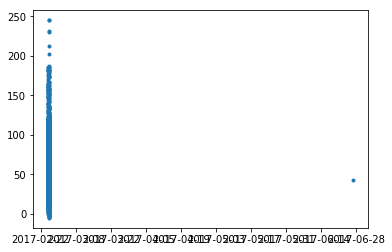

In [96]:
plt.plot(source_df.index, source_df.f_int, "." )

In [97]:
source_df = source_df[source_df.index.year == 2017]

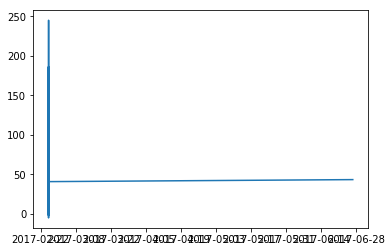

In [98]:
%matplotlib inline
plt.plot(source_df.index, source_df.f_int)

In [73]:
source_df = source_df[source_df.index.year == 2017]

In [87]:
source_df[source_df.index.year == 2018]

,taustart_ts,band,dataset,decl,decl_err,eta_int,extract_type,f_datapoints,f_int,f_int_err,freq_eff,ra,ra_err,runcatid,tau_time,v_int,wm_decl,wm_ra,xtrsrc
taustart_ts,,,,,,,,,,,,,,,,,,,


In [92]:
del source_df

In [100]:
np.where(source_df.index.year ==2018)

(array([], dtype=int64),)